<a href="https://colab.research.google.com/github/Ankur7470/nlp-assignment2/blob/main/NLP_assgn2_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
!pip install gensim


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [153]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing the necessary libraries

In [154]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



## EDA

### Loading the Sentiment Analysis Dataset

In [155]:
sentiment_data = pd.read_csv("./dataset/sentimentdataset.csv")

### Information about the Dataset

In [156]:
sentiment_data.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [157]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [158]:
sentiment_data = sentiment_data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour'])

### Working with Sentiment Labels

In [159]:
print("\nNo. of Unique Sentiments:", sentiment_data['Sentiment'].nunique())


No. of Unique Sentiments: 279


In [160]:
sentiment_data['Sentiment'].unique()

array([' Positive  ', ' Negative  ', ' Neutral   ', ' Anger        ',
       ' Fear         ', ' Sadness      ', ' Disgust      ',
       ' Happiness    ', ' Joy          ', ' Love         ',
       ' Amusement    ', ' Enjoyment    ', ' Admiration   ',
       ' Affection    ', ' Awe          ', ' Disappointed ',
       ' Surprise     ', ' Acceptance   ', ' Adoration    ',
       ' Anticipation ', ' Bitter       ', ' Calmness     ',
       ' Confusion    ', ' Excitement   ', ' Kind         ',
       ' Pride        ', ' Shame        ', ' Confusion ', ' Excitement ',
       ' Shame ', ' Elation       ', ' Euphoria      ', ' Contentment   ',
       ' Serenity      ', ' Gratitude     ', ' Hope          ',
       ' Empowerment   ', ' Compassion    ', ' Tenderness    ',
       ' Arousal       ', ' Enthusiasm    ', ' Fulfillment  ',
       ' Reverence     ', ' Compassion', ' Fulfillment   ', ' Reverence ',
       ' Elation   ', ' Despair         ', ' Grief           ',
       ' Loneliness     

In [161]:
# Stripping the leading and trailing spaces from each sentiment
sentiment_data['Sentiment'] = [sentiment.strip() for sentiment in sentiment_data['Sentiment']]

In [162]:
print("\nNo. of Unique Sentiments after stripping the unwanted spaces from sentiment labels :", sentiment_data['Sentiment'].nunique())


No. of Unique Sentiments after stripping the unwanted spaces from sentiment labels : 191


In [163]:
sentiment_counts = sentiment_data['Sentiment'].value_counts()
print("Sentiment Counts:\n")
sentiment_counts[:10]

Sentiment Counts:



Sentiment
Positive       45
Joy            44
Excitement     37
Contentment    19
Neutral        18
Gratitude      18
Curiosity      16
Serenity       15
Happy          14
Nostalgia      11
Name: count, dtype: int64

### Checking for Duplicate Text Entries

In [164]:
print("No. of Duplicate Text Entries", sentiment_data['Text'].duplicated().sum())

No. of Duplicate Text Entries 25


In [165]:
# Filtering texts that appear more than once
duplicate_texts = sentiment_data.groupby('Text').size().reset_index(name='count')
duplicate_texts[duplicate_texts['count'] > 1]

,Text,count
1,"A compassionate rain, tears of empathy fallin...",3
4,"A free spirit soaring on the wings of dreams,...",2
12,"A playful escapade in the carnival of life, c...",3
40,"Bathed in the golden hues of gratefulness, a ...",2
52,Charting a course through the waves of hopefu...,2
59,"Confident strides in the dance of life, a bal...",2
81,"Dismissive gestures, a curtain drawn to shiel...",2
93,"Embraced by the hopeful dawn, a gardener sowi...",3
148,"Floating on clouds of inspiration, an artist ...",2
176,"Hopeful whispers of wind, carrying the promis...",2


### Handling Duplicate Text Entries

In [166]:
# Keeping the first occurrence of each duplicate
sentiment_data = sentiment_data.drop_duplicates(subset=['Text'], keep='first')

In [167]:
print("No. of Duplicate Text Entries (keeping only the first occurrence): ", sentiment_data['Text'].duplicated().sum())

No. of Duplicate Text Entries (keeping only the first occurrence):  0


In [168]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 0 to 731
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       707 non-null    object
 1   Sentiment  707 non-null    object
dtypes: object(2)
memory usage: 16.6+ KB


## Data Preprocessing

### Encoding the sentiment labels

In [169]:
label_encoder = LabelEncoder()


### Applying Preprocessing to all the texts

In [170]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

sentiment_data['Tokenized Text'] = [preprocess_text(text) for text in sentiment_data['Text'].values]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mbash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mbash\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Dataset after Preprocessing/Tokenization of texts and Label Encoding of Sentiments

In [171]:
sentiment_data.head(10)

,Text,Sentiment,Tokenized Text
0,Enjoying a beautiful day at the park! ...,Positive,"[enjoying, beautiful, day, park]"
1,Traffic was terrible this morning. ...,Negative,"[traffic, terrible, morning]"
2,Just finished an amazing workout! 💪 ...,Positive,"[finished, amazing, workout]"
3,Excited about the upcoming weekend getaway! ...,Positive,"[excited, upcoming, weekend, getaway]"
4,Trying out a new recipe for dinner tonight. ...,Neutral,"[trying, new, recipe, dinner, tonight]"
5,Feeling grateful for the little things in lif...,Positive,"[feeling, grateful, little, thing, life]"
6,Rainy days call for cozy blankets and hot coc...,Positive,"[rainy, day, call, cozy, blanket, hot, cocoa]"
7,The new movie release is a must-watch! ...,Positive,"[new, movie, release, mustwatch]"
8,Political discussions heating up on the timel...,Negative,"[political, discussion, heating, timeline]"
9,Missing summer vibes and beach days. ...,Neutral,"[missing, summer, vibe, beach, day]"


In [172]:
len(np.unique(sentiment_data['Sentiment']))

# Convert NumPy array to list
arr_list = np.unique(sentiment_data['Sentiment']).tolist()
import json
# Save as JSON file
with open("array.json", "w") as f:
    json.dump(arr_list, f)

# np.savetxt("array.csv", arr_list, delimiter=",", fmt="%d")

In [ ]:
# positive = {
#     "Acceptance", "Accomplishment", "Admiration", "Adoration", "Affection", "Amazement",
#     "Appreciation", "Blessed", "Breakthrough", "Calmness", "Celebration", "Charm",
#     "Compassion", "Confidence", "Contentment", "Creativity", "Curiosity", "Dazzle",
#     "Determination", "Ecstasy", "Elation", "Elegance", "Empowerment", "Enchantment",
#     "Engagement", "Enjoyment", "Enthusiasm", "Euphoria", "Excitement", "FestiveJoy",
#     "Freedom", "Friendship", "Fulfillment", "Grateful", "Gratitude", "Happiness",
#     "Happy", "Harmony", "Heartwarming", "Hope", "Hopeful", "Inspiration", "Inspired",
#     "Joy", "Kindness", "Love", "Marvel", "Motivation", "Optimism", "Overjoyed",
#     "Playful", "Positivity", "Pride", "Proud", "Radiance", "Rejuvenation", "Relief",
#     "Resilience", "Romance", "Satisfaction", "Serenity", "Success", "Thrill",
#     "Tranquility", "Triumph", "Vibrancy", "Wonder", "Wonderment", "Positive", "Amusement",
#     "Awe", "Compassionate", "JoyfulReunion", "Colorful", "PlayfulJoy", "Confident",
#     "Celestial Wonder", "Spark", "Imagination", "Thrilling Journey", "Whimsy", "Touched",
#     "Adventure", "Adrenaline", "Exploration", "Hypnotic", "Energy", "Tenderness", 
#     "Free-spirited", "Grandeur", "Zest", "Kind"
# }

# negative = {
#     "Anger", "Anxiety", "Bad", "Betrayal", "Bitter", "Bitterness", "Bittersweet",
#     "Darkness", "Desolation", "Despair", "Desperation", "Devastated", "Disappointed",
#     "Disappointment", "Disgust", "Frustration", "Grief", "Hate", "Heartache",
#     "Heartbreak", "Helplessness", "Intimidation", "Isolation", "Jealous", "Jealousy",
#     "Loneliness", "Loss", "LostLove", "Melancholy", "Miscalculation", "Numbness",
#     "Overwhelmed", "Regret", "Resentment", "Ruins", "Sad", "Sadness", "Shame", "Sorrow",
#     "Suffering", "Suspense", "Sympathy", "Yearning", "Fear", "Fearful", "Negative",
#     "Mischievous", "Embarrassed", "Envy", "Envious", "Dismissive", "Frustrated",
#     "Apprehensive", "Pensive", "Exhaustion", "Indifference", "Confusion", "Solace"
# }

# neutral = {
#     "Ambivalence", "Anticipation", "Arousal", "ArtisticBurst", "Boredom",
#     "Captivation", "Challenge", "Connection", "Contemplation", "Coziness",
#     "Creative Inspiration", "Culinary Adventure", "CulinaryOdyssey", "Emotion",
#     "EmotionalStorm", "Empathetic", "Envisioning History", "Iconic", "Immersion",
#     "InnerJourney", "Journey", "Melodic", "Mesmerizing", "Mindfulness",
#     "Nature's Beauty", "Neutral", "Nostalgia", "Obstacle", "Ocean's Freedom",
#     "Pressure", "Reflection", "Renewed Effort", "Reverence", "Runway Creativity",
#     "Serenity", "Solitude", "Surprise", "Whispers of the Past", "Winter Magic",
#     "Intrigue", "DreamChaser", "Joy in Baking"
# }

In [882]:
positive = {
    "Acceptance", "Accomplishment", "Admiration", "Adoration", "Affection", "Amazement",
    "Appreciation", "Blessed", "Breakthrough", "Calmness", "Celebration", "Charm",
    "Compassion", "Confidence", "Contentment", "Creativity", "Curiosity", "Dazzle",
    "Determination", "Ecstasy", "Elation", "Elegance", "Empowerment", "Enchantment",
    "Engagement", "Enjoyment", "Enthusiasm", "Euphoria", "Excitement", "FestiveJoy",
    "Freedom", "Friendship", "Fulfillment", "Grateful", "Gratitude", "Happiness",
    "Happy", "Harmony", "Heartwarming", "Hope", "Hopeful", "Inspiration", "Inspired",
    "Joy", "Kindness", "Love", "Marvel", "Motivation", "Optimism", "Overjoyed",
    "Playful", "Positivity", "Pride", "Proud", "Radiance", "Rejuvenation", "Relief",
    "Resilience", "Romance", "Satisfaction", "Serenity", "Success", "Thrill",
    "Tranquility", "Triumph", "Vibrancy", "Wonder", "Wonderment", "Positive", "Amusement",
    "Awe", "Compassionate", "JoyfulReunion", "Colorful", "PlayfulJoy", "Confident",
    "Celestial Wonder", "Spark",  "Thrilling Journey", "Whimsy", "Touched",
    "Adrenaline", "Exploration", "Hypnotic", "Energy", "Tenderness", 
    "Free-spirited", "Grandeur", "Zest", "Kind",
    "Adventure"
}

negative = {
    "Anger", "Anxiety", "Bad", "Betrayal", "Bitter", "Bitterness", "Bittersweet",
    "Darkness", "Desolation", "Despair", "Desperation", "Devastated", "Disappointed",
    "Disappointment", "Disgust", "Frustration", "Grief", "Hate", "Heartache",
    "Heartbreak", "Helplessness", "Intimidation", "Isolation", "Jealous", "Jealousy",
    "Loneliness", "Loss", "LostLove", "Melancholy",  "Numbness",
    "Overwhelmed", "Regret", "Resentment", "Ruins", "Sad", "Sadness", "Shame", "Sorrow",
    "Suffering",  "Sympathy",  "Fear", "Fearful", "Negative",
    "Mischievous", "Embarrassed", "Envy", "Envious", "Dismissive", "Frustrated",
    "Apprehensive", "Pensive", "Exhaustion", "Indifference", "Confusion", "Solace", "Suspense","Yearning"
}

neutral = {
    "Ambivalence", "Anticipation", "Arousal", "ArtisticBurst", "Boredom","Miscalculation",
    "Captivation", "Challenge", "Connection", "Contemplation", "Coziness",
    "Creative Inspiration", "Culinary Adventure", "CulinaryOdyssey", "Emotion",
    "EmotionalStorm", "Empathetic", "Envisioning History", "Iconic", "Immersion",
    "InnerJourney", "Journey", "Melodic", "Mesmerizing", "Mindfulness",
    "Nature's Beauty", "Neutral", "Nostalgia", "Obstacle", "Ocean's Freedom",
    "Pressure", "Reflection", "Renewed Effort", "Reverence", "Runway Creativity",
    "Serenity", "Solitude", "Surprise", "Whispers of the Past", "Winter Magic",
    "Intrigue", "DreamChaser", "Joy in Baking","Imagination"
}


In [883]:

sentiment_mapping = {}

for sentiment in positive:
    sentiment_mapping[sentiment] = "Positive"
for sentiment in negative:
    sentiment_mapping[sentiment] = "Negative"
for sentiment in neutral:
    sentiment_mapping[sentiment] = "Neutral"

# Function to classify sentiments
def classify_sentiment(sentiment):
    return sentiment_mapping.get(sentiment, "Unknown")  # Default to "Unknown" if not found
 # Default to "Unknown" if not found

# Apply function to create a new column
sentiment_data["Sentiment_Group"] = sentiment_data["Sentiment"].apply(classify_sentiment)



In [884]:
# Filter rows where Sentiment_Group is "Unknown"
unknown_sentiments = sentiment_data[sentiment_data["Sentiment_Group"] == "Unknown"]

# Print results
print(unknown_sentiments[["Sentiment", "Sentiment_Group"]])


Empty DataFrame
Columns: [Sentiment, Sentiment_Group]
Index: []


In [886]:
sentiment_data['Encoded Sentiment'] = label_encoder.fit_transform(sentiment_data['Sentiment_Group'])
sentiment_data

,Text,Sentiment,Tokenized Text,Sentiment_Group,Encoded Sentiment
0,Enjoying a beautiful day at the park! ...,Positive,"[enjoying, beautiful, day, park]",Positive,2
1,Traffic was terrible this morning. ...,Negative,"[traffic, terrible, morning]",Negative,0
2,Just finished an amazing workout! 💪 ...,Positive,"[finished, amazing, workout]",Positive,2
3,Excited about the upcoming weekend getaway! ...,Positive,"[excited, upcoming, weekend, getaway]",Positive,2
4,Trying out a new recipe for dinner tonight. ...,Neutral,"[trying, new, recipe, dinner, tonight]",Neutral,1
...,...,...,...,...,...
727,Collaborating on a science project that receiv...,Happy,"[collaborating, science, project, received, re...",Positive,2
728,Attending a surprise birthday party organized ...,Happy,"[attending, surprise, birthday, party, organiz...",Positive,2
729,Successfully fundraising for a school charity ...,Happy,"[successfully, fundraising, school, charity, i...",Positive,2
730,"Participating in a multicultural festival, cel...",Happy,"[participating, multicultural, festival, celeb...",Positive,2


### Extracting the Relevant Columns

In [887]:
tokenized_texts = sentiment_data['Tokenized Text'].values
labels = sentiment_data['Encoded Sentiment'].values
labels

array([2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1,
       2, 2, 1, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 0,
       0, 1, 1, 2, 2, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 0, 0, 1, 1,
       2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Word2Vec Training & Text Vectorization

#### Train custom Word2Vec model

In [888]:
word2vec_model = Word2Vec(
    sentences=tokenized_texts,  # List of tokenized sentences
    vector_size=100,            # Size of the word vectors
    window=5,                   # Maximum distance between the current and predicted word
    min_count=2,                # Ignores words with frequency lower than this
    workers=4,                  # Number of CPU cores
    sg = 1
)

In [889]:
word2vec_model.save("word2vec.model")

#### Word2Vec vocabulary details

In [890]:
print("Word2Vec vocabulary size:", len(word2vec_model.wv))
print("Sample words in vocabulary:", list(word2vec_model.wv.index_to_key)[:10])

Word2Vec vocabulary size: 978
Sample words in vocabulary: ['new', 'life', 'day', 'joy', 'moment', 'feeling', 'like', 'friend', 'heart', 'night']


In [891]:
# sample word vector
word2vec_model.wv['dream']

array([-0.00134503,  0.00749628,  0.01095018, -0.01083784, -0.00843607,
       -0.01750925, -0.00180087,  0.01882845, -0.00985678, -0.01170151,
        0.00149062, -0.01250158,  0.00785652, -0.00074926,  0.00553191,
       -0.00010326,  0.00367569, -0.01256671,  0.00342911, -0.02101866,
        0.00043042,  0.00021563,  0.01052013, -0.01023289, -0.00771293,
        0.00548167, -0.00563027, -0.01094416,  0.00374056,  0.00462585,
        0.00411291,  0.00455317,  0.01100338,  0.00785194,  0.00418933,
        0.01263985,  0.00027707, -0.00781501, -0.0131604 , -0.01429575,
        0.00093814, -0.00445574, -0.00603149,  0.00528949, -0.00315149,
       -0.0103952 , -0.00441027, -0.00483939, -0.00533885,  0.00661615,
       -0.00096278, -0.00697056, -0.0093878 ,  0.00331642, -0.00594855,
        0.00445199, -0.00104791, -0.00168783, -0.00209766,  0.00430703,
       -0.00645585, -0.00095533, -0.00142288, -0.00096768, -0.0190217 ,
        0.00868203, -0.00413591, -0.00284536, -0.00577498,  0.00

#### Converting the Tokenized texts into Sentence vectors

In [892]:
# using average of word vectors to represent sentences.
def text_to_vectors(text, model, vector_size=100):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Average word vectors
    else:
        return np.zeros(vector_size)  # Return zero vector if no words are in vocabulary

In [893]:
vectorized_texts = np.array([text_to_vectors(text, word2vec_model) for text in tokenized_texts])

In [894]:
vectorized_texts.shape

(707, 100)

In [895]:
print("First Sentence in Tokenized form:\n", tokenized_texts[0])
print("\nFirst Sentence in Vectorized form:\n", vectorized_texts[0])  # Printing the first 5 word vectors from the first sentence

First Sentence in Tokenized form:
 ['enjoying', 'beautiful', 'day', 'park']

First Sentence in Vectorized form:
 [-0.00513012  0.00556102 -0.00458171 -0.00411881 -0.00185008 -0.0036347
 -0.00493423  0.00625088 -0.00465942  0.00146757 -0.00988239 -0.00609408
  0.00271998  0.001852    0.00251819 -0.00564513  0.00096643  0.00044542
 -0.0010063  -0.00850558  0.00213788 -0.00097737 -0.00280217 -0.00342641
  0.00315668 -0.00055318 -0.00039253  0.00011234 -0.00105617  0.00550717
  0.00352085 -0.00223756  0.00176134 -0.00107218 -0.00067751  0.00136745
  0.00445134 -0.00372059 -0.00085777 -0.00333346 -0.00470237 -0.00290568
  0.00027674  0.00112983  0.00304642 -0.00339039  0.00042893 -0.00145852
 -0.00047056  0.00164184  0.0007676  -0.00551474 -0.00073693 -0.00200427
  0.00049124  0.00226406  0.00074432  0.00218045 -0.00711484 -0.00230741
 -0.0008423   0.00310927 -0.00239204  0.00160744 -0.00837686  0.00427378
  0.00692792  0.00294463 -0.00246845  0.00964445  0.00128749 -0.00122129
  0.00452331

### Preparing Data for Training

In [896]:
X = vectorized_texts
y = labels

In [897]:
unique_values, counts = np.unique(y, return_counts=True)
len(unique_values)

3

In [898]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [899]:
# DataLoader for training
batch_size = 32
dataset = SentimentDataset(X, y)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)


train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [900]:
test_dataset.dataset.X

tensor([[-0.0051,  0.0056, -0.0046,  ..., -0.0036,  0.0035, -0.0001],
        [-0.0108,  0.0017,  0.0066,  ..., -0.0005, -0.0010, -0.0027],
        [-0.0025,  0.0078, -0.0020,  ...,  0.0023, -0.0050,  0.0019],
        ...,
        [-0.0063,  0.0068,  0.0011,  ..., -0.0118,  0.0045, -0.0058],
        [-0.0030,  0.0051,  0.0029,  ..., -0.0051,  0.0043, -0.0009],
        [-0.0040,  0.0045,  0.0014,  ..., -0.0078,  0.0039, -0.0043]])

In [901]:
class Model(nn.Module) :
    #4 input -> HL1 -> HL2 -> output 3

    def __init__(self, in_features= 100, h1 = 128, h2 = 256, h3 = 64, h4 = 256, out_features = 3):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.out = nn.Linear(h4, out_features)
         # Dropout layer (0.2 probability)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        x = F.relu(self.fc3(x))
        # x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.out(x)

        return x

In [902]:
torch.manual_seed(42)

model = Model() # creating model
criterion = nn.CrossEntropyLoss() # defining loss 

optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

epochs = 100


In [903]:
def train_model(model, criterion, optimizer, epochs) :
    losses = []

    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:  # iterate over mini-batches
            
            # forward pass
            y_pred = model(batch_X)

            # compute loss
            loss = criterion(y_pred, batch_y)

            # track losses
            losses.append(loss.detach().numpy())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # losses.append(loss.detach().numpy())
        # Print loss every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return losses

In [904]:
train_loss = train_model(model, criterion, optimizer, epochs=300)

Epoch 0, Loss: 0.9177469611167908
Epoch 10, Loss: 1.0580660104751587
Epoch 20, Loss: 0.8813546299934387
Epoch 30, Loss: 1.0991830825805664
Epoch 40, Loss: 0.7577584981918335
Epoch 50, Loss: 1.0447360277175903
Epoch 60, Loss: 0.9758217930793762
Epoch 70, Loss: 1.0108442306518555
Epoch 80, Loss: 0.4952749013900757
Epoch 90, Loss: 0.6289622187614441
Epoch 100, Loss: 0.6218728423118591
Epoch 110, Loss: 0.2830459475517273
Epoch 120, Loss: 0.6512624025344849
Epoch 130, Loss: 0.6425368785858154
Epoch 140, Loss: 0.31166863441467285
Epoch 150, Loss: 0.4093059003353119
Epoch 160, Loss: 0.3767774999141693
Epoch 170, Loss: 0.1854674518108368
Epoch 180, Loss: 0.23350495100021362
Epoch 190, Loss: 0.17182734608650208
Epoch 200, Loss: 0.23608767986297607
Epoch 210, Loss: 0.06779283285140991
Epoch 220, Loss: 0.07627496868371964
Epoch 230, Loss: 0.021699169650673866
Epoch 240, Loss: 0.7400538325309753
Epoch 250, Loss: 0.015190904960036278
Epoch 260, Loss: 0.02444573864340782
Epoch 270, Loss: 0.001278261

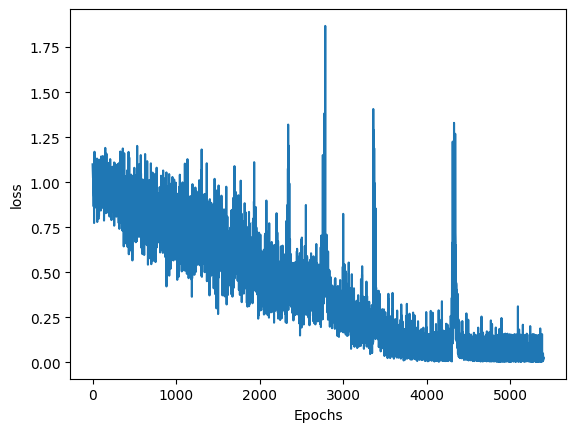

In [905]:
plt.plot(range(len(train_loss)), train_loss)
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

Accuracy: 0.6479


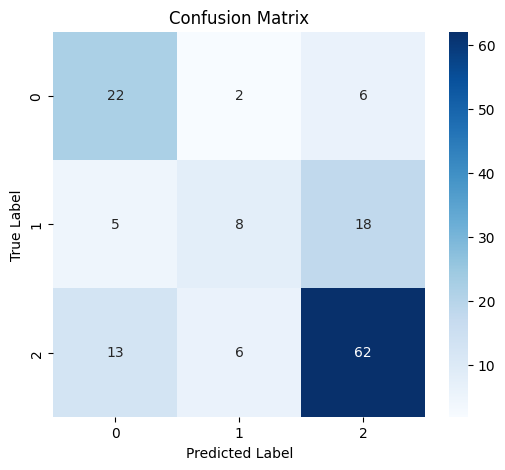

In [906]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import accuracy_score, confusion_matrix

# Function to make predictions using test_loader
def predict(model, test_loader):
    model.eval()  # Set to evaluation mode (disable dropout, batch norm)
    
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():  # No gradient tracking for inference
        for batch_X, batch_y in test_loader:  # Iterate through batches
            y_pred = model(batch_X)  # Forward pass
            y_pred_classes = torch.argmax(y_pred, dim=1)  # Get class with highest probability
            
            # Store predictions and actual labels
            y_true_list.extend(batch_y.numpy())  # Convert to NumPy & store
            y_pred_list.extend(y_pred_classes.numpy())  # Convert to NumPy & store

    return np.array(y_true_list), np.array(y_pred_list)

# Get predictions
y_test_true, y_test_pred = predict(model, test_loader)

# Compute accuracy
accuracy = accuracy_score(y_test_true, y_test_pred)
print(f'Accuracy: {accuracy:.4f}')

# Compute confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_true), yticklabels=np.unique(y_test_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [907]:
import time
timestamp = int(time.time()) 
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create filename with timestamp
model_filename = f"model_{timestamp}.pth"
torch.save(model, f"./models/model_{timestamp}.pth")